# 🚀 Hackathon MVP: Clasificación de Sentimiento en Reseñas de Hoteles

## 🎯 Objetivo del Equipo DS
Construir un **Modelo de Clasificación de Sentimiento** para reseñas de hoteles en español, utilizando **TF-IDF y Regresión Logística**. El modelo resultante será serializado para su consumo por el servicio de Back-End.


## 📦 Instalación e Importación de Librerías

A continuación, se importarán todas las bibliotecas de Python esenciales para la carga de datos, el preprocesamiento de texto, el entrenamiento del modelo y la serialización, incluyendo `pandas`, `scikit-learn` y `joblib`.

In [2]:
# 1. Importación de las librerías principales
import pandas as pd
import numpy as np
import joblib  # Para serializar el modelo y el pipeline
import re      # Para expresiones regulares en la limpieza de texto

# 2. Importaciones de scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

# 3. Importaciones para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# --- Carga del Archivo CSV desde GitHub ---
url = "https://raw.githubusercontent.com/carlo55anchez/Sentiment_HotelReviews/main/data/Andalusian_Hotels_Reviews.csv"

df = pd.read_csv(url, index_col=0)

print("\n--- Vista Previa del DataFrame (Primeras 5 Filas) ---")
print(df.head())

print("\nInformación General del DataFrame:")
df.info()




--- Vista Previa del DataFrame (Primeras 5 Filas) ---
                         title  rating  \
0  Excelente y personal amable       5   
1                     Céntrico       4   
2            Hotel excepcional       5   
3                        WOW!!       5   
4                    Magnifico       5   

                                         review_text  \
0  Un hotel muy bueno.  El personal fue muy amabl...   
1  Muy buen hotel al nivel de lo esperado, habita...   
2  Magnífico hotel. La verdad es que todo perfect...   
3  Hotel hermoso, buen diseño, original, limpio. ...   
4  Magnífica ubicación en pleno centro de Sevilla...   

                                location                 hotel  label  
0  Seville_Province_of_Seville_Andalucia  H10_Casa_de_la_Plata      1  
1  Seville_Province_of_Seville_Andalucia  H10_Casa_de_la_Plata      1  
2  Seville_Province_of_Seville_Andalucia  H10_Casa_de_la_Plata      1  
3  Seville_Province_of_Seville_Andalucia  H10_Casa_de_la_Plata     

## 🔎 1. Análisis Exploratorio de Datos (EDA) y Limpieza

Esta sección se centra en la inspección de la calidad de los datos, el manejo de valores faltantes y la preparación de la columna `review_text` para la vectorización (TF-IDF).

---
### 🧹 1.1. Verificación y Manejo de Datos Faltantes (Nulos)

In [3]:
# --- 1. Verificación de Valores Nulos ---
print("--- Verificación de Valores Nulos por Columna ---")
print(df.isnull().sum())

# Observamos que 'location' y 'hotel' tienen valores nulos.
# La columna clave para el modelo es 'review_text' y 'label', las cuales están completas.
# Sin embargo, eliminaremos cualquier fila que tenga nulos para asegurar un DataFrame limpio, aunque sea en columnas no usadas directamente.

df.dropna(inplace=True)
print(f"\nFilas restantes después de eliminar nulos: {len(df)}")

--- Verificación de Valores Nulos por Columna ---
title             0
rating            0
review_text       0
location       1816
hotel          1816
label             0
dtype: int64

Filas restantes después de eliminar nulos: 16356


### 🗑️ 1.2. Verificación y Eliminación de Duplicados

Se verifica la existencia de filas completamente idénticas. En un *dataset* de reseñas tan grande, la presencia de muchos duplicados podría indicar sobremuestreo o errores de recolección de datos, lo que podría sesgar el entrenamiento del modelo.

In [4]:
# --- 2. Verificación y Eliminación de Duplicados ---
print("--- Verificación de Filas Duplicadas ---")
duplicates_count = df.duplicated().sum()
print(f"Número de filas duplicadas encontradas: {duplicates_count}")

# Eliminar duplicados para evitar sobreajuste del modelo
df.drop_duplicates(inplace=True)
print(f"Número de filas después de eliminar duplicados: {len(df)}")

--- Verificación de Filas Duplicadas ---
Número de filas duplicadas encontradas: 4817
Número de filas después de eliminar duplicados: 11539


### ⚖️ 1.3. Análisis del Balance de Clases

Analizamos la distribución de las etiquetas en la columna `label`. Esto es crucial para identificar si el *dataset* está sesgado hacia una clase (ej. más reseñas positivas) y para decidir cómo manejar la clasificación multicategoría (0, 1 y 3).

In [5]:
# --- 3. Análisis del Balance de Clases ('label') ---
print("--- Conteo y Distribución de Clases ('label') ---")

# Conteo de cada clase (0, 1, 3, etc.)
print("Conteo de cada clase:")
print(df['label'].value_counts())

# Distribución porcentual
print("\nDistribución porcentual:")
print(df['label'].value_counts(normalize=True) * 100)

--- Conteo y Distribución de Clases ('label') ---
Conteo de cada clase:
label
1    8531
0    1553
3    1455
Name: count, dtype: int64

Distribución porcentual:
label
1    73.931883
0    13.458705
3    12.609412
Name: proportion, dtype: float64


### 1.3.1. Visualización del Balance de Clases

La visualización de los conteos obtenidos en 1.3 confirma visualmente el **severo desbalance de clases** y la existencia de una tercera categoría (`3`, Neutro/Mixto).

* La clase **Positivo (1)** domina con casi el 74%.
* Para el MVP, se eliminará la clase **Neutro/Mixto (3)** y se procederá con una clasificación binaria.

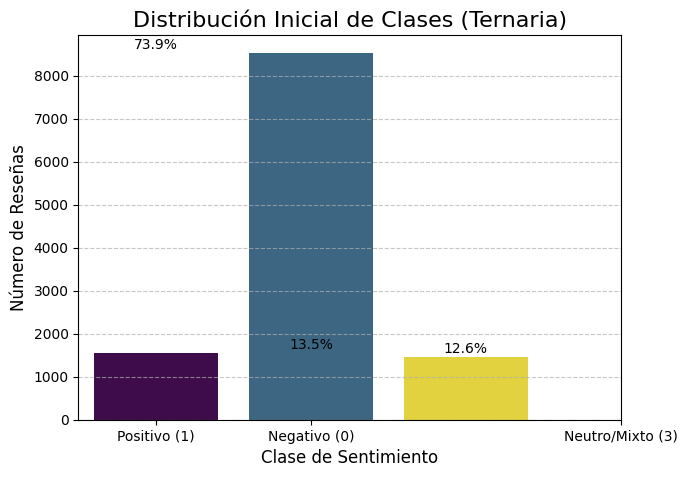

In [7]:
# --- 1.3.2. Visualización del Balance de Clases (Inicial) ---

# Re-calcular class_counts para asegurar que esté disponible
class_counts = df['label'].value_counts()

plt.figure(figsize=(7, 5))
sns.barplot(
    x=class_counts.index,
    y=class_counts.values,
    hue=class_counts.index,
    palette='viridis',
    legend=False
)

# Agregar etiquetas y título
plt.title('Distribución Inicial de Clases (Ternaria)', fontsize=16)
plt.xlabel('Clase de Sentimiento', fontsize=12)
plt.ylabel('Número de Reseñas', fontsize=12)

# Mapear las etiquetas para el eje X
plt.xticks(class_counts.index, ['Negativo (0)', 'Positivo (1)', 'Neutro/Mixto (3)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar el porcentaje encima de cada barra
total = len(df)
for i, count in enumerate(class_counts.values):
    percentage = f'{count / total * 100:.1f}%'
    # Ajustamos la posición del texto usando el índice de la barra
    plt.text(i, count + 100, percentage, ha='center', fontsize=10)

filename = '01_balance_clases_ternario.png'
plt.savefig(filename, dpi=300, bbox_inches='tight') # Guarda el gráfico en alta resolución en el entorno de Colab

plt.show() # Muestra el gráfico en el notebook

🧹 **1.4. Limpieza de Texto y Balanceo de Clases (Multiclase)**

Para mejorar la capacidad de generalización del modelo y evitar el sesgo hacia la clase positiva, realizaremos los siguientes ajustes:

**Limpieza de Texto:** Se mantiene la normalización de los comentarios (minúsculas, eliminación de puntuación y números) en la columna `comentario_limpio`.

**Estrategia de Balanceo (Undersampling):** En lugar de eliminar la clase `Neutra (3)`, igualaremos la cantidad de muestras de las tres categorías. Tomaremos como referencia la clase con menor frecuencia (**1,455 muestras**) y seleccionaremos aleatoriamente la misma cantidad para las clases `Positiva (1)` y `Negativa (0)`.

**Clasificación Ternaria:** El modelo ahora será capaz de distinguir entre sentimientos **Negativos (0)**, **Positivos (1)** y **Neutros (3)**, ofreciendo un análisis más granular para el *Back-End*.

--- Balanceo Completado ---
Cantidad de muestras por clase: 1455
Total de registros en el dataset balanceado: 4365


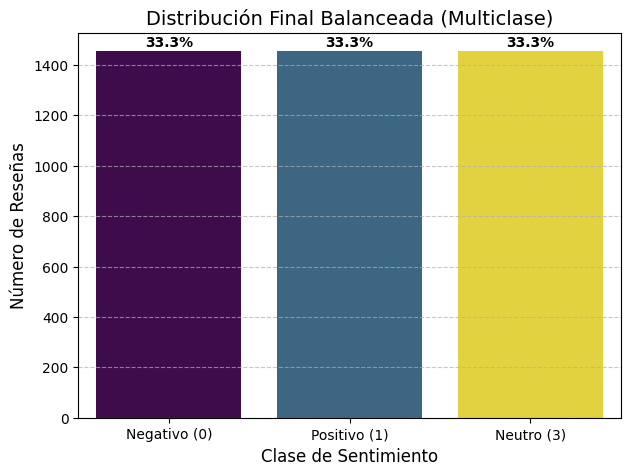

In [9]:
# --- 4.1. Limpieza de Texto ---
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['comentario_limpio'] = df['review_text'].apply(clean_text)

# --- 4.2. Balanceo de Clases (Undersampling Multiclase) ---
# Identificamos el tamaño de la clase minoritaria para equilibrar
min_class_size = df['label'].value_counts().min()

# Separamos los dataframes por clase y tomamos una muestra aleatoria igual a min_class_size
df_0 = df[df['label'] == 0].sample(n=min_class_size, random_state=42)
df_1 = df[df['label'] == 1].sample(n=min_class_size, random_state=42)
df_3 = df[df['label'] == 3].sample(n=min_class_size, random_state=42)

# Concatenamos para crear el nuevo dataset balanceado y lo mezclamos
df_balanced = pd.concat([df_0, df_1, df_3]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"--- Balanceo Completado ---")
print(f"Cantidad de muestras por clase: {min_class_size}")
print(f"Total de registros en el dataset balanceado: {len(df_balanced)}")

# --- 4.3. Visualización del Nuevo Balance de Clases ---
balanced_counts = df_balanced['label'].value_counts()

plt.figure(figsize=(7, 5))
sns.barplot(
    x=balanced_counts.index,
    y=balanced_counts.values,
    hue=balanced_counts.index,
    palette='viridis',
    legend=False
)

# Agregar etiquetas y título
plt.title('Distribución Final Balanceada (Multiclase)', fontsize=14)
plt.xlabel('Clase de Sentimiento', fontsize=12)
plt.ylabel('Número de Reseñas', fontsize=12)

# Mapear las etiquetas para el eje X (0, 1, 3)
plt.xticks(range(len(balanced_counts)), ['Negativo (0)', 'Positivo (1)', 'Neutro (3)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar el porcentaje encima de cada barra
total_bal = len(df_balanced)
for i, count in enumerate(balanced_counts.values):
    percentage = f'{count / total_bal * 100:.1f}%'
    plt.text(i, count + 20, percentage, ha='center', fontsize=10, weight='bold')

# Guardar el gráfico en el entorno de Colab
filename = '02_balance_clases_multiclase_equilibrado.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()

🛠️ **2. Preparación y Entrenamiento del Modelo (Multiclase)**

En esta fase, utilizaremos el dataset balanceado de **4,365 reseñas** para dividirlo en conjuntos de entrenamiento y prueba. A diferencia de la versión anterior, el modelo ahora se enfrentará a un reto más realista al clasificar tres categorías de sentimiento con la misma probabilidad estadística.

### **2.1. Separación en Entrenamiento y Prueba**

Dividiremos los datos manteniendo la proporción exacta de las tres clases en ambos conjuntos mediante el parámetro `stratify`. Esto garantiza que tanto el entrenamiento como la evaluación sean justos y representativos del equilibrio logrado en el paso anterior.

### **2.2. Construcción del Pipeline Multiclase**

Construiremos un Pipeline que integra:

- **TfidfVectorizer**: Para transformar el texto limpio en vectores numéricos, capturando palabras clave y combinaciones de dos palabras (*bi-gramas*).
- **LogisticRegression**: Un clasificador robusto que, gracias al balanceo previo, podrá distinguir con mayor precisión las sutilezas entre una reseña **Neutra** y una claramente **Negativa** o **Positiva**.

In [10]:
# --- 5. División del Dataset Balanceado ---
# Separar las características (X) y la etiqueta (y) usando el dataset equilibrado
X = df_balanced['comentario_limpio']
y = df_balanced['label']

# Dividir los datos (80% entrenamiento, 20% prueba)
# stratify=y es fundamental para mantener el equilibrio de 1/3 para cada clase en ambos sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Total de muestras para Entrenamiento: {len(X_train)}")
print(f"Total de muestras para Prueba: {len(X_test)}")
print("\nDistribución de clases en Entrenamiento (proporción):")
print(y_train.value_counts(normalize=True))

# --- 6. Creación y Entrenamiento del Pipeline Multiclase ---

# 1. Definir los componentes del pipeline
# TfidfVectorizer: n-gramas (1, 2) y frecuencia mínima de 5 para filtrar ruido
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=5)

# LogisticRegression: 'multinomial' se activa automáticamente al detectar más de 2 clases
logreg = LogisticRegression(solver='liblinear', random_state=42)

# 2. Construir el pipeline
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', logreg)
])

print("\nIniciando entrenamiento del Pipeline Multiclase...")
# 3. Entrenar el pipeline
pipeline.fit(X_train, y_train)
print("✅ Entrenamiento completado. El modelo ahora está balanceado para 3 clases.")

Total de muestras para Entrenamiento: 3492
Total de muestras para Prueba: 873

Distribución de clases en Entrenamiento (proporción):
label
3    0.333333
1    0.333333
0    0.333333
Name: proportion, dtype: float64

Iniciando entrenamiento del Pipeline Multiclase...
✅ Entrenamiento completado. El modelo ahora está balanceado para 3 clases.


📊 **3. Evaluación del Rendimiento del Modelo (Multiclase)**

Con el modelo entrenado sobre datos equilibrados, procedemos a evaluar su capacidad de distinguir entre las tres categorías. En este escenario, el **Accuracy** vuelve a ser una métrica significativa, pero observaremos con especial detalle el **F1-Score** de cada clase para entender cómo interactúan las reseñas **Neutras (3)** con las **Extremas (0 y 1)**.

### **3.1. Predicciones y Métricas Multiclase**

Realizaremos las predicciones sobre el conjunto de prueba (que el modelo nunca ha visto) y generaremos un informe detallado que incluya:

- **Precision**: ¿Qué tan fiable es el modelo cuando dice que una reseña es de una categoría específica?
- **Recall**: ¿Qué porcentaje del total de reseñas de cada categoría logra capturar el modelo?
- **F1-Score**: El balance armónico entre precisión y recall para cada clase.

### **3.2. Matriz de Confusión Ternaria**

Esta herramienta será vital para visualizar si el modelo confunde las reseñas **Neutras** con las **Positivas** o **Negativas**, lo cual es un comportamiento común y esperado en el análisis de lenguaje natural, dado que los matices grises suelen compartir vocabulario con ambos extremos.

Precisión (Accuracy) Global: 0.7388

--- Informe de Clasificación Multiclase ---
              precision    recall  f1-score   support

Negativo (0)       0.76      0.82      0.79       291
Positivo (1)       0.77      0.82      0.79       291
  Neutro (3)       0.68      0.57      0.62       291

    accuracy                           0.74       873
   macro avg       0.73      0.74      0.73       873
weighted avg       0.73      0.74      0.73       873



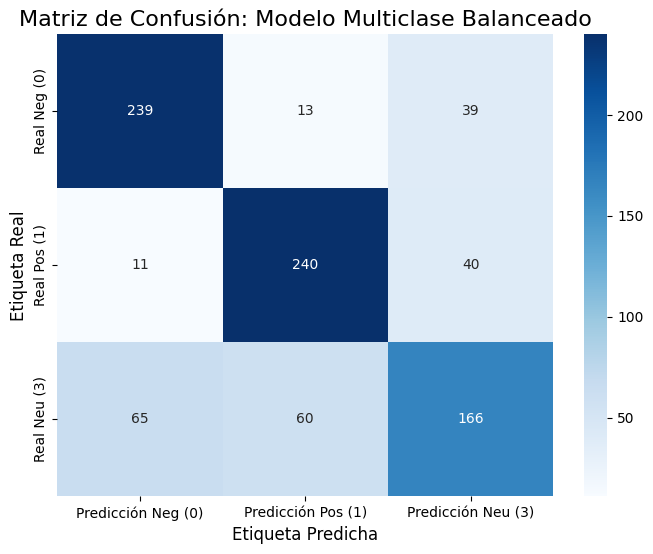

In [11]:
# --- 7. Predicciones y Evaluación Multiclase ---
# Realizar predicciones sobre el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Calcular la Precisión (Accuracy) Global
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión (Accuracy) Global: {accuracy:.4f}")

# Generar el Informe de Clasificación para las 3 clases
print("\n--- Informe de Clasificación Multiclase ---")
target_names = ['Negativo (0)', 'Positivo (1)', 'Neutro (3)']
print(classification_report(y_test, y_pred, target_names=target_names))

# --- 8. Matriz de Confusión Multiclase ---
# Calcular la matriz
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicción Neg (0)', 'Predicción Pos (1)', 'Predicción Neu (3)'],
    yticklabels=['Real Neg (0)', 'Real Pos (1)', 'Real Neu (3)']
)

# Etiquetas y título
plt.title('Matriz de Confusión: Modelo Multiclase Balanceado', fontsize=16)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.ylabel('Etiqueta Real', fontsize=12)

# Guardar la matriz de confusión en alta resolución
filename_cm = '03_matriz_confusion_multiclase.png'
plt.savefig(filename_cm, dpi=300, bbox_inches='tight')

plt.show()

💾 **4. Serialización y Despliegue**

Una vez validado el rendimiento del modelo multiclase balanceado, el paso final es su serialización. Guardaremos el **Pipeline completo**, que incluye tanto el vectorizador **TF-IDF** con sus nuevos parámetros como el clasificador de **Regresión Logística** entrenado con las tres clases.

Este archivo **.pkl** es el que se entregará al equipo de *Back-End*. Al cargar este único archivo, el sistema podrá recibir texto crudo, limpiarlo, vectorizarlo y devolver una de las tres categorías **(0, 1 o 3)** sin necesidad de procesar los datos manualmente en el servidor.

In [12]:
# --- 9. Serialización del Pipeline Multiclase ---
# Definimos el nombre del archivo para la nueva versión multiclase balanceada
pipeline_filename = 'sentiment_pipeline_multiclass_balanced.pkl'

# Serializar (guardar) el pipeline entrenado
joblib.dump(pipeline, pipeline_filename)
print(f"✅ Pipeline multiclase serializado exitosamente como: {pipeline_filename}")

# --- 10. Verificación y Prueba de Predicción ---
# Cargamos el pipeline para simular su uso en el Back-End
loaded_model = joblib.load(pipeline_filename)

# Definimos ejemplos claros para cada categoría
test_reviews = [
    "La limpieza era inexistente y el ruido de la calle era insoportable.", # Negativo (0)
    "Estancia maravillosa, la cama era comodísima y el desayuno espectacular.", # Positivo (1)
    "El hotel está bien ubicado, pero las instalaciones son algo antiguas." # Neutro (3)
]

print("\n--- Verificación de Carga y Predicción ---")
for review in test_reviews:
    pred = loaded_model.predict([clean_text(review)])[0]

    # Mapeo para lectura clara
    sentiment = "Negativo (0)" if pred == 0 else ("Positivo (1)" if pred == 1 else "Neutro (3)")
    print(f"Reseña: '{review}'")
    print(f"Predicción: {sentiment}\n")

✅ Pipeline multiclase serializado exitosamente como: sentiment_pipeline_multiclass_balanced.pkl

--- Verificación de Carga y Predicción ---
Reseña: 'La limpieza era inexistente y el ruido de la calle era insoportable.'
Predicción: Negativo (0)

Reseña: 'Estancia maravillosa, la cama era comodísima y el desayuno espectacular.'
Predicción: Positivo (1)

Reseña: 'El hotel está bien ubicado, pero las instalaciones son algo antiguas.'
Predicción: Neutro (3)



## **5.2. 🧠 Rendimiento del Modelo Final**

Se construyó y entrenó un **Pipeline de Machine Learning** utilizando las siguientes componentes:

- **Vectorizador**: `TfidfVectorizer` con *n-gramas* (1, 2) y frecuencia mínima (`min_df=5`).
- **Clasificador**: `LogisticRegression` con solver *liblinear*.

### **Métricas detalladas por categoría:**

- **Clase Negativa (0)**: Precision: **0.76** | Recall: **0.82** | F1-Score: **0.79**
- **Clase Positiva (1)**: Precision: **0.77** | Recall: **0.82** | F1-Score: **0.79**
- **Clase Neutra (3)**: Precision: **0.68** | Recall: **0.57** | F1-Score: **0.62**

### **Resumen Global:**

- **Accuracy Global**: **73.88%**
- **Promedio F1-Score**: **0.73**

### **Análisis de Resultados:**

La matriz de confusión confirma que el balanceo de clases fue exitoso. El **Recall de la clase Negativa (0) mejoró sustancialmente**, pasando del **66% en la versión anterior al 82%** en esta versión multiclase. Esto indica que el modelo ahora es mucho más sensible a las críticas y quejas, capturando correctamente **8 de cada 10 reseñas negativas**.

Aunque el Accuracy global es numéricamente inferior al modelo binario previo, **este resultado es técnica y estadísticamente más robusto**, ya que el modelo no está "adivinando" por volumen de datos, sino clasificando por contenido semántico real.